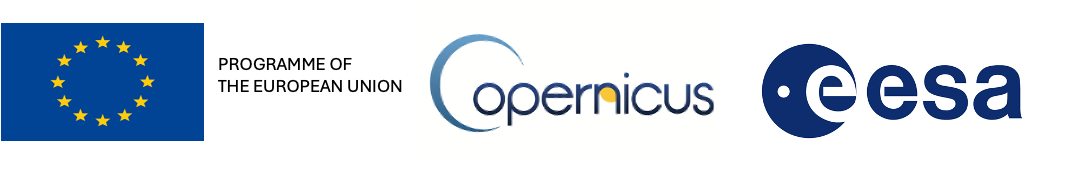

# SAFE vs ZARR Metadata extraction using GDAL

## Table of Contents

1. [Introduction](#Introduction)
2. [Using GDAL for ZARR metadata extraction and interpretation](#Using-GDAL-for-ZARR-metadata-extraction-and-interpretation)
3. [Using GDAL for SAFE metadata extraction and interpretation](#Using-GDAL-for-SAFE-metadata-extraction-and-interpretation)
4. [Using XARRAY for ZARR metadata extraction and interpretation](#Using-XARRAY-for-ZARR-metadata-extraction-and-interpretation)
5. [The Missing Metadata in ZARR](#The-Missing-Metadata-in-ZARR)

## Introduction

This notebook presents the most efficient methods for extracting metadata from Sentinel-2 L2A data using GDAL for both ZARR and SAFE formats. Additionally, it covers metadata extraction from ZARR using XARRAY and highlights the metadata available in SAFE but missing in ZARR.

General Observations while creating this notebook
1. When opening the **ZARR format** with either **Xarray** or **GDAL**, it is not possible to extract **Radiometric and Atmospheric metadata**. However, the **SAFE file** contains these metadata, except for the **radiometric offset**.

2. Associating **band names with their respective resolutions** is not straightforward in both ZARR and SAFE.

3. The **ZARR format** stores attributes differently to the **SAFE format**. However, ZARR lacks an additional dictionary named **'metadata'**, which is accessible in SAFE using **GDAL’s `GetMetadata` method**. This missing metadata dictionary contains **quantification values** (not specific to individual bands) along with **general information, processing details, quality checks, atmospheric conditions, cloud and surface data, special values, and footprint information**, but lacks clear information on Spectral and band information.
4. Also in the **SAFE format**, the **zenith and azimuth angles** are not extractable.


## Using GDAL for ZARR metadata extraction and interpretation

In [1]:
from osgeo import gdal

# Open the Zarr dataset
dataset = gdal.OpenEx(
    "/mnt/CEPH_PROJECTS/test/S2B_MSIL2A_20250206T101109_N0511_R022_T32TPS_20250206T122414.zarr",
    gdal.OF_MULTIDIM_RASTER,
)
root_group = dataset.GetRootGroup()

attributes = {}
for attribute in root_group.GetAttributes():
    attributes[attribute.GetName()] = attribute.Read()

attributes.keys()

/home/sdhinakaran/micromamba/envs/eopf-zarr/lib/python3.11/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


dict_keys(['other_metadata', 'stac_discovery'])

### General Metadata

- Mission ID: Sentinel-2A, Sentinel-2B or Sentinel-2C
- Product ID: Unique identifier for the data product
- Product Type: (e.g., Level-1C, Level-2A)
- Processing Baseline: The software version used for processing
- Processing Time: Time when the data was processed
- Cloud Cover Percentage: Estimated cloud coverage in the scene

In [2]:
mission_id = attributes["stac_discovery"]["properties"]["mission"]
product_id = attributes["stac_discovery"]["id"]
product_type = attributes["stac_discovery"]["properties"]["processing:level"]
processing_baseline = attributes["stac_discovery"]["properties"]["eopf:baseline"]
processing_time = attributes["stac_discovery"]["properties"]["created"]
cloud_cover = attributes["stac_discovery"]["properties"]["eo:cloud_cover"]

print("General Metadata")
print(f"Mission ID: {mission_id}")
print(f"Product ID: {product_id}")
print(f"Product Type: {product_type}")
print(f"Processing Baseline: {processing_baseline}")
print(f"Processing Time: {processing_time}")
print(f"Cloud Cover Percentage: {cloud_cover}")

General Metadata
Mission ID: sentinel-2
Product ID: S2B_MSIL2A_20250206T101109_N0511_R022_T32TPS_20250206T122414.SAFE
Product Type: L2A
Processing Baseline: 05.11
Processing Time: 2025-02-06T12:24:14+00:00
Cloud Cover Percentage: 0.189419


### Acquisition & Geolocation

- Sensing Time: Timestamp of image acquisition
- Tile ID: Sentinel-2 tiling grid reference (e.g., T31TCH)
- Relative Orbit Number: Orbit number within the 10-day repeat cycle
- Latitude & Longitude Bounds: Bounding box coordinates of the scene
- Mean Sun Zenith Angle: Average sun elevation during acquisition
- Mean Sun Azimuth Angle: Average sun azimuth angle during acquisition

In [3]:
sensing_time = attributes["stac_discovery"]["properties"]["start_datetime"]
tile_id = attributes["stac_discovery"]["id"].split("_")[-2]
relative_orbit_number = attributes["stac_discovery"]["properties"]["sat:relative_orbit"]
bbox = attributes["stac_discovery"]["bbox"]
mean_sun_zenith_angle = attributes["other_metadata"][
    "mean_sun_zenith_angle_in_deg_for_all_bands_all_detectors"
]
mean_sun_azimuth_angle = attributes["other_metadata"][
    "mean_sun_azimuth_angle_in_deg_for_all_bands_all_detectors"
]

print("\nAcquisition & Geolocation")
print(f"Sensing Time: {sensing_time}")
print(f"Tile ID: {tile_id}")
print(f"Relative Orbit Number: {relative_orbit_number}")
print(f"BBOX: {bbox}")
print(f"Mean Sun Zenith Angle: {mean_sun_zenith_angle}")
print(f"Mean Sun Azimuth Angle: {mean_sun_azimuth_angle}")


Acquisition & Geolocation
Sensing Time: 2025-02-06T10:11:09.025000+00:00
Tile ID: T32TPS
Relative Orbit Number: 22
BBOX: [11.755584916064224, 45.93349650488509, 10.290484068727272, 46.94616825397537]
Mean Sun Zenith Angle: 64.0039475781829
Mean Sun Azimuth Angle: 160.658277466103


### Spectral & Band Information

- Band List: Names of available bands (e.g., B01–B12)
- 
Wavelength Range: Central wavelength and bandwidth for each ban
- 
Spatial Resolution: 10m, 20m, or 60m depending on the band

In [4]:
print("\nSpectral & Band Information")

bands = attributes["stac_discovery"]["properties"]["bands"]
resolution_mapping = attributes["stac_discovery"]["properties"]["eopf:resolutions"]

# Process the resolution mapping into a dictionary where band names are the keys
formatted_resolution_mapping = {}
for key, value in resolution_mapping.items():
    band_names = key.replace("bands ", "").split(", ")
    for band in band_names:
        band = band.strip().lower()  # Standardize case and remove spaces
        if (
            band.isdigit() or band == "8a"
        ):  # Ensure "b" prefix for numerical bands & "8a"
            band = f"b{band}"
        formatted_resolution_mapping[band] = value + "m"

# Loop through bands and print with resolution
for band in bands:
    band_name = band["name"].strip().lower()  # Ensure matching format
    central_wavelength = band["center_wavelength"]
    resolution = formatted_resolution_mapping.get(band_name, "Unknown")

    print(
        f"Band Name: {band_name}, Central Wavelength: {central_wavelength} nm, Resolution: {resolution}"
    )


Spectral & Band Information
Band Name: b01, Central Wavelength: 442.3 nm, Resolution: 60m
Band Name: b02, Central Wavelength: 492.3 nm, Resolution: 10m
Band Name: b03, Central Wavelength: 559.0 nm, Resolution: 10m
Band Name: b04, Central Wavelength: 665.0 nm, Resolution: 10m
Band Name: b05, Central Wavelength: 703.8 nm, Resolution: 20m
Band Name: b06, Central Wavelength: 739.1 nm, Resolution: 20m
Band Name: b07, Central Wavelength: 779.7 nm, Resolution: 20m
Band Name: b08, Central Wavelength: 833.0 nm, Resolution: 10m
Band Name: b8a, Central Wavelength: 864.0 nm, Resolution: 20m
Band Name: b09, Central Wavelength: 943.2 nm, Resolution: 60m
Band Name: b10, Central Wavelength: 1376.9 nm, Resolution: 60m
Band Name: b11, Central Wavelength: 1610.4 nm, Resolution: 20m
Band Name: b12, Central Wavelength: 2185.7 nm, Resolution: 20m


## Using GDAL for SAFE metadata extraction and interpretation

In [5]:
from osgeo import gdal

# Open the Sentinel-2 SAFE file using GDAL
file_path = '/home/sdhinakaran/test_eopf_cpm/data/S2B_MSIL2A_20250206T101109_N0511_R022_T32TPS_20250206T122414.SAFE.zip'
dataset = gdal.Open(file_path)

# Extract metadata
metadata = dataset.GetMetadata()


### General Metadata

- Mission ID: Sentinel-2A, Sentinel-2B or Sentinel-2C
- Product ID: Unique identifier for the data product
- Product Type: (e.g., Level-1C, Level-2A)
- Processing Baseline: The software version used for processing
- Processing Time: Time when the data was processed
- Cloud Cover Percentage: Estimated cloud coverage in the scene

In [6]:
# General Metadata
mission_id = metadata.get('DATATAKE_1_SPACECRAFT_NAME', 'N/A')
product_id = metadata.get('PRODUCT_URI', 'N/A')
product_type = metadata.get('PRODUCT_TYPE', 'N/A')
processing_baseline = metadata.get('PROCESSING_BASELINE', 'N/A')
processing_time = metadata.get('GENERATION_TIME', 'N/A')
cloud_cover_percentage = metadata.get('CLOUD_COVERAGE_ASSESSMENT', 'N/A')

print("General Metadata")
print(f"Mission ID: {mission_id}")
print(f"Product ID: {product_id}")
print(f"Product Type: {product_type}")
print(f"Processing Baseline: {processing_baseline}")
print(f"Processing Time: {processing_time}")
print(f"Cloud Cover Percentage: {cloud_cover_percentage}")

General Metadata
Mission ID: Sentinel-2B
Product ID: S2B_MSIL2A_20250206T101109_N0511_R022_T32TPS_20250206T122414.SAFE
Product Type: S2MSI2A
Processing Baseline: 05.11
Processing Time: 2025-02-06T12:24:14.000000Z
Cloud Cover Percentage: 0.189419


### Acquisition & Geolocation

- Sensing Time: Timestamp of image acquisition
- Tile ID: Sentinel-2 tiling grid reference (e.g., T31TCH)
- Relative Orbit Number: Orbit number within the 10-day repeat cycle
- Latitude & Longitude Bounds: Bounding box coordinates of the scene
- Mean Sun Zenith Angle: Average sun elevation during acquisition
- Mean Sun Azimuth Angle: Average sun azimuth angle during acquisition

In [7]:
# Acquisition & Geolocation
sensing_time = metadata.get('DATATAKE_1_DATATAKE_SENSING_START', 'N/A')
tile_id = metadata.get('PRODUCT_URI', 'N/A').split("_")[-2]
relative_orbit_number = metadata.get('DATATAKE_1_SENSING_ORBIT_NUMBER', 'N/A')
footprint = metadata.get('FOOTPRINT', 'N/A')
mean_sun_zenith_angle = metadata.get('SUN_ZENITH', 'N/A')  # Check for correct key for sun zenith angle
mean_sun_azimuth_angle = metadata.get('SUN_AZIMUTH', 'N/A')  # Check for correct key for sun azimuth angle

print("\nAcquisition & Geolocation")
print(f"Sensing Time: {sensing_time}")
print(f"Tile ID: {tile_id}")
print(f"Relative Orbit Number: {relative_orbit_number}")
print(f"Latitude & Longitude Bounds: {footprint}")
print(f"Mean Sun Zenith Angle: {mean_sun_zenith_angle}")
print(f"Mean Sun Azimuth Angle: {mean_sun_azimuth_angle}")


Acquisition & Geolocation
Sensing Time: 2025-02-06T10:11:09.025Z
Tile ID: T32TPS
Relative Orbit Number: 22
Latitude & Longitude Bounds: POLYGON((10.314035280374382 46.94616825397537, 11.755584916064224 46.920536388192055, 11.706254333045143 45.93349650488509, 10.290484068727272 45.95826451839171, 10.314035280374382 46.94616825397537))
Mean Sun Zenith Angle: N/A
Mean Sun Azimuth Angle: N/A


### Radiometric & Atmospheric Metadata

- Quantification Value: Scale factor to convert raw digital numbers (DN) to reflectance
- Radiometric Offset: Applied to correct sensor readings

In [8]:
metadata = dataset.GetMetadata()
# Extract values safely
quantification_value_AOT = metadata.get("AOT_QUANTIFICATION_VALUE")
quantification_value_BOA = metadata.get("BOA_QUANTIFICATION_VALUE")
quantification_value_WVP = metadata.get("WVP_QUANTIFICATION_VALUE")

# Define units if available
aot_unit = metadata.get(
    "AOT_QUANTIFICATION_VALUE_UNIT", ""
)  # Adjust this if units are stored under a different key
boa_unit = metadata.get("BOA_QUANTIFICATION_VALUE_UNIT", "")
wvp_unit = metadata.get("WVP_QUANTIFICATION_VALUE_UNIT", "")

# Ensure we don't print 'None' or include units if the value is missing
aot_display = (
    f"{quantification_value_AOT} {aot_unit}".strip()
    if quantification_value_AOT not in [None, "None"]
    else ""
)
boa_display = (
    f"{quantification_value_BOA} {boa_unit}".strip()
    if quantification_value_BOA not in [None, "None"]
    else ""
)
wvp_display = (
    f"{quantification_value_WVP} {wvp_unit}".strip()
    if quantification_value_WVP not in [None, "None"]
    else ""
)

print("\nRadiometric & Athmospheric Metadata")
# Print output
print(f"AOT Quantification Value: {aot_display}")
print(f"BOA Quantification Value: {boa_display}")
print(f"WVP Quantification Value: {wvp_display}")


Radiometric & Athmospheric Metadata
AOT Quantification Value: 1000.0 none
BOA Quantification Value: 10000 none
WVP Quantification Value: 1000.0 cm


In [9]:
subdatasets = dataset.GetSubDatasets()
subdatasets

[('SENTINEL2_L2A:/vsizip//home/sdhinakaran/test_eopf_cpm/data/S2B_MSIL2A_20250206T101109_N0511_R022_T32TPS_20250206T122414.SAFE.zip/S2B_MSIL2A_20250206T101109_N0511_R022_T32TPS_20250206T122414.SAFE/MTD_MSIL2A.xml:10m:EPSG_32632',
  'Bands B2, B3, B4, B8, AOT, WVP with 10m resolution, UTM 32N'),
 ('SENTINEL2_L2A:/vsizip//home/sdhinakaran/test_eopf_cpm/data/S2B_MSIL2A_20250206T101109_N0511_R022_T32TPS_20250206T122414.SAFE.zip/S2B_MSIL2A_20250206T101109_N0511_R022_T32TPS_20250206T122414.SAFE/MTD_MSIL2A.xml:20m:EPSG_32632',
  'Bands B5, B6, B7, B8A, B11, B12, AOT, CLD, SCL, SNW, WVP with 20m resolution, UTM 32N'),
 ('SENTINEL2_L2A:/vsizip//home/sdhinakaran/test_eopf_cpm/data/S2B_MSIL2A_20250206T101109_N0511_R022_T32TPS_20250206T122414.SAFE.zip/S2B_MSIL2A_20250206T101109_N0511_R022_T32TPS_20250206T122414.SAFE/MTD_MSIL2A.xml:60m:EPSG_32632',
  'Bands B1, B9, AOT, CLD, SCL, SNW, WVP with 60m resolution, UTM 32N'),
 ('SENTINEL2_L2A:/vsizip//home/sdhinakaran/test_eopf_cpm/data/S2B_MSIL2A_202502

## Using XARRAY for ZARR metadata extraction and interpretation

In [10]:
import xarray as xr

ds = xr.open_zarr(
    "/mnt/CEPH_PROJECTS/test/S2B_MSIL2A_20250206T101109_N0511_R022_T32TPS_20250206T122414.zarr",
    consolidated=True,
)

/home/sdhinakaran/micromamba/envs/eopf-zarr/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


### General Metadata

- Mission ID: Sentinel-2A, Sentinel-2B or Sentinel-2C
- Product ID: Unique identifier for the data product
- Product Type: (e.g., Level-1C, Level-2A)
- Processing Baseline: The software version used for processing
- Processing Time: Time when the data was processed
- Cloud Cover Percentage: Estimated cloud coverage in the scene

In [11]:
mission_id = ds.attrs["stac_discovery"]["properties"]["mission"]
product_id = ds.attrs["stac_discovery"]["id"]
product_type = ds.attrs["stac_discovery"]["properties"]["processing:level"]
processing_baseline = ds.attrs["stac_discovery"]["properties"]["eopf:baseline"]
processing_time = ds.attrs["stac_discovery"]["properties"]["created"]
cloud_cover = ds.attrs["stac_discovery"]["properties"]["eo:cloud_cover"]

print("General Metadata")
print(f"Mission ID: {mission_id}")
print(f"Product ID: {product_id}")
print(f"Product Type: {product_type}")
print(f"Processing Baseline: {processing_baseline}")
print(f"Processing Time: {processing_time}")
print(f"Cloud Cover Percentage: {cloud_cover}")

General Metadata
Mission ID: sentinel-2
Product ID: S2B_MSIL2A_20250206T101109_N0511_R022_T32TPS_20250206T122414.SAFE
Product Type: L2A
Processing Baseline: 05.11
Processing Time: 2025-02-06T12:24:14+00:00
Cloud Cover Percentage: 0.189419


### Acquisition & Geolocation

- Sensing Time: Timestamp of image acquisition
- Tile ID: Sentinel-2 tiling grid reference (e.g., T31TCH)
- Relative Orbit Number: Orbit number within the 10-day repeat cycle
- Latitude & Longitude Bounds: Bounding box coordinates of the scene
- Mean Sun Zenith Angle: Average sun elevation during acquisition
- Mean Sun Azimuth Angle: Average sun azimuth angle during acquisition

In [12]:
sensing_time = ds.attrs["stac_discovery"]["properties"]["start_datetime"]
tile_id = ds.attrs["stac_discovery"]["id"].split("_")[-2]
relative_orbit_number = ds.attrs["stac_discovery"]["properties"]["sat:relative_orbit"]
bbox = ds.attrs["stac_discovery"]["bbox"]
mean_sun_zenith_angle = ds.other_metadata[
    "mean_sun_zenith_angle_in_deg_for_all_bands_all_detectors"
]
mean_sun_azimuth_angle = ds.other_metadata[
    "mean_sun_azimuth_angle_in_deg_for_all_bands_all_detectors"
]

print("\nAcquisition & Geolocation")
print(f"Sensing Time: {sensing_time}")
print(f"Tile ID: {tile_id}")
print(f"Relative Orbit Number: {relative_orbit_number}")
print(f"BBOX: {bbox}")
print(f"Mean Sun Zenith Angle: {mean_sun_zenith_angle}")
print(f"Mean Sun Azimuth Angle: {mean_sun_azimuth_angle}")


Acquisition & Geolocation
Sensing Time: 2025-02-06T10:11:09.025000+00:00
Tile ID: T32TPS
Relative Orbit Number: 22
BBOX: [11.755584916064224, 45.93349650488509, 10.290484068727272, 46.94616825397537]
Mean Sun Zenith Angle: 64.0039475781829
Mean Sun Azimuth Angle: 160.658277466103


### Spectral & Band Information

- Band List: Names of available bands (e.g., B01–B12)
- 
Wavelength Range: Central wavelength and bandwidth for each ban
- 
Spatial Resolution: 10m, 20m, or 60m depending on the band

In [13]:
bands = ds.attrs["stac_discovery"]["properties"]["bands"]
resolution_mapping = ds.attrs["stac_discovery"]["properties"]["eopf:resolutions"]

# Process the resolution mapping into a dictionary where band names are the keys
formatted_resolution_mapping = {}
for key, value in resolution_mapping.items():
    band_names = key.replace("bands ", "").split(", ")
    for band in band_names:
        band = band.strip().lower()  # Standardize case and remove spaces
        if (
            band.isdigit() or band == "8a"
        ):  # Ensure "b" prefix for numerical bands & "8a"
            band = f"b{band}"
        formatted_resolution_mapping[band] = value + "m"

print("Spectral & Band Information")
# Loop through bands and print with resolution
for band in bands:
    band_name = band["name"].strip().lower()  # Ensure matching format
    central_wavelength = band["center_wavelength"]
    resolution = formatted_resolution_mapping.get(band_name, "Unknown")

    print(
        f"Band Name: {band_name}, Central Wavelength: {central_wavelength} nm, Resolution: {resolution}"
    )

Spectral & Band Information
Band Name: b01, Central Wavelength: 442.3 nm, Resolution: 60m
Band Name: b02, Central Wavelength: 492.3 nm, Resolution: 10m
Band Name: b03, Central Wavelength: 559.0 nm, Resolution: 10m
Band Name: b04, Central Wavelength: 665.0 nm, Resolution: 10m
Band Name: b05, Central Wavelength: 703.8 nm, Resolution: 20m
Band Name: b06, Central Wavelength: 739.1 nm, Resolution: 20m
Band Name: b07, Central Wavelength: 779.7 nm, Resolution: 20m
Band Name: b08, Central Wavelength: 833.0 nm, Resolution: 10m
Band Name: b8a, Central Wavelength: 864.0 nm, Resolution: 20m
Band Name: b09, Central Wavelength: 943.2 nm, Resolution: 60m
Band Name: b10, Central Wavelength: 1376.9 nm, Resolution: 60m
Band Name: b11, Central Wavelength: 1610.4 nm, Resolution: 20m
Band Name: b12, Central Wavelength: 2185.7 nm, Resolution: 20m


## The Missing Metadata in ZARR 

The missing metadata which can be found in the SAFE file but is not extractable from the ZARR file.

In [14]:
from osgeo import gdal

# Open the Sentinel-2 SAFE file using GDAL
file_path = "/mnt/CEPH_PROJECTS/test/S2B_MSIL2A_20250206T101109_N0511_R022_T32TPS_20250206T122414.SAFE.zip"
dataset = gdal.Open(file_path)

metadata = dataset.GetMetadata()
metadata

{'AOT_QUANTIFICATION_VALUE': '1000.0',
 'AOT_QUANTIFICATION_VALUE_UNIT': 'none',
 'AOT_RETRIEVAL_ACCURACY': '0.0',
 'AOT_RETRIEVAL_METHOD': 'SEN2COR_DDV',
 'BOA_QUANTIFICATION_VALUE': '10000',
 'BOA_QUANTIFICATION_VALUE_UNIT': 'none',
 'CAST_SHADOW_PERCENTAGE': '29.224494',
 'CLOUDY_PIXEL_OVER_LAND_PERCENTAGE': '0.181666',
 'CLOUD_COVERAGE_ASSESSMENT': '0.189419',
 'CLOUD_SHADOW_PERCENTAGE': '0.004638',
 'DATATAKE_1_DATATAKE_SENSING_START': '2025-02-06T10:11:09.025Z',
 'DATATAKE_1_DATATAKE_TYPE': 'INS-NOBS',
 'DATATAKE_1_ID': 'GS2B_20250206T101109_041375_N05.11',
 'DATATAKE_1_SENSING_ORBIT_DIRECTION': 'DESCENDING',
 'DATATAKE_1_SENSING_ORBIT_NUMBER': '22',
 'DATATAKE_1_SPACECRAFT_NAME': 'Sentinel-2B',
 'DEGRADED_ANC_DATA_PERCENTAGE': '0.0',
 'DEGRADED_MSI_DATA_PERCENTAGE': '0',
 'FOOTPRINT': 'POLYGON((10.314035280374382 46.94616825397537, 11.755584916064224 46.920536388192055, 11.706254333045143 45.93349650488509, 10.290484068727272 45.95826451839171, 10.314035280374382 46.946168253975